In [1]:
import sys
sys.path.append('../../')

In [2]:
# imports
import os
import sys
import math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from distnet import DistResNeXt50
from dataset import InternData
import matplotlib.patches as patches
from albumentations import OneOf, Compose
from albumentations import (HorizontalFlip,
                            HueSaturationValue,
                            RandomBrightnessContrast,
                            Blur,
                            GaussNoise,
                            CLAHE,
                            CoarseDropout,
                            RGBShift,
                            BboxParams)

In [3]:
# set torch random seed
torch.manual_seed(42)

In [4]:
# define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# define an albumentations augmentation routine
alb_aug_list = [HorizontalFlip(p=1),  
                HueSaturationValue(hue_shift_limit=20,
                                   sat_shift_limit=30,
                                   val_shift_limit=20,
                                   p=1),
                RandomBrightnessContrast(brightness_limit=0.2,
                                         contrast_limit=0.2,
                                         brightness_by_max=True,
                                         p=1), 
                Blur(blur_limit=7, #blurring kernel size
                     p=1),
                GaussNoise(var_limit=(10.0, 50.0), #Variance range for noise
                           mean=0,
                           p=1),
                CLAHE(clip_limit=4.0, #Contrast limited adaptive histogram equalization
                      tile_grid_size=(8, 8),
                      p=1),
                RGBShift(p=1)
                ]

train_aug = OneOf(alb_aug_list, p=0.7)

In [6]:
# create a transforms routine
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                              std=[0.229, 0.224, 0.225])
                                            ])

# create training dataset and loader
size = 1024
train_data = InternData(img_dir='/irad_mounts/lambda-quad-5-data/beholder/intern_data/jpg-data/',
                      meta_path='/irad_mounts/lambda-quad-5-data/beholder/intern_data/annotation.csv',
                      augs = train_aug,
                      transforms=transforms,
                      size=size)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=2, drop_last=True, shuffle=True, collate_fn=train_data.collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


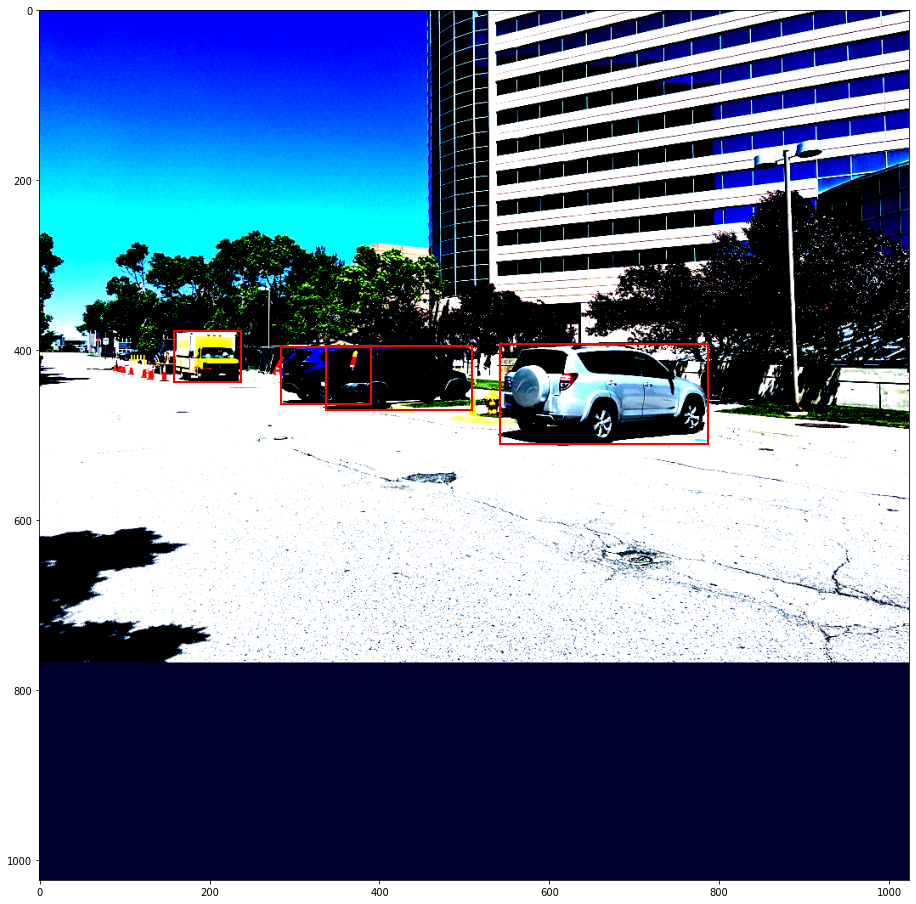

In [7]:
# plot some example training data
idx = 11
image,boxes,distances,classes = train_data.__getitem__(idx)
image,boxes,classes = image.numpy(),boxes.numpy(),classes.numpy()
fig,ax = plt.subplots(figsize=(20,16))

# # fix color pixel range
# shape = np.shape(image)
# image = image.flatten()
# min_pix = np.min(image)
# max_pix = np.max(image)
# image = np.apply_along_axis(lambda x: (x - min_pix) / (max_pix - min_pix), 0, image)
# image = np.reshape(image, shape)

ax.imshow(np.transpose(image, (1,2,0)))
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0],boxes[i][3]),boxes[i][2]-boxes[i][0],boxes[i][1]-boxes[i][3], linewidth=2, edgecolor='r', facecolor='none', label='object')
    ax.add_patch(rect)
plt.show()

In [8]:
# create test dataset and loader
test_data = InternData(img_dir='/irad_mounts/lambda-quad-5-data/beholder/intern_data/jpg-data/',
                      meta_path='/irad_mounts/lambda-quad-5-data/beholder/intern_data/annotation.csv',
                      transforms=transforms, size=size, split='test')

testloader = torch.utils.data.DataLoader(test_data, batch_size=2, drop_last=True, shuffle=False, collate_fn=test_data.collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


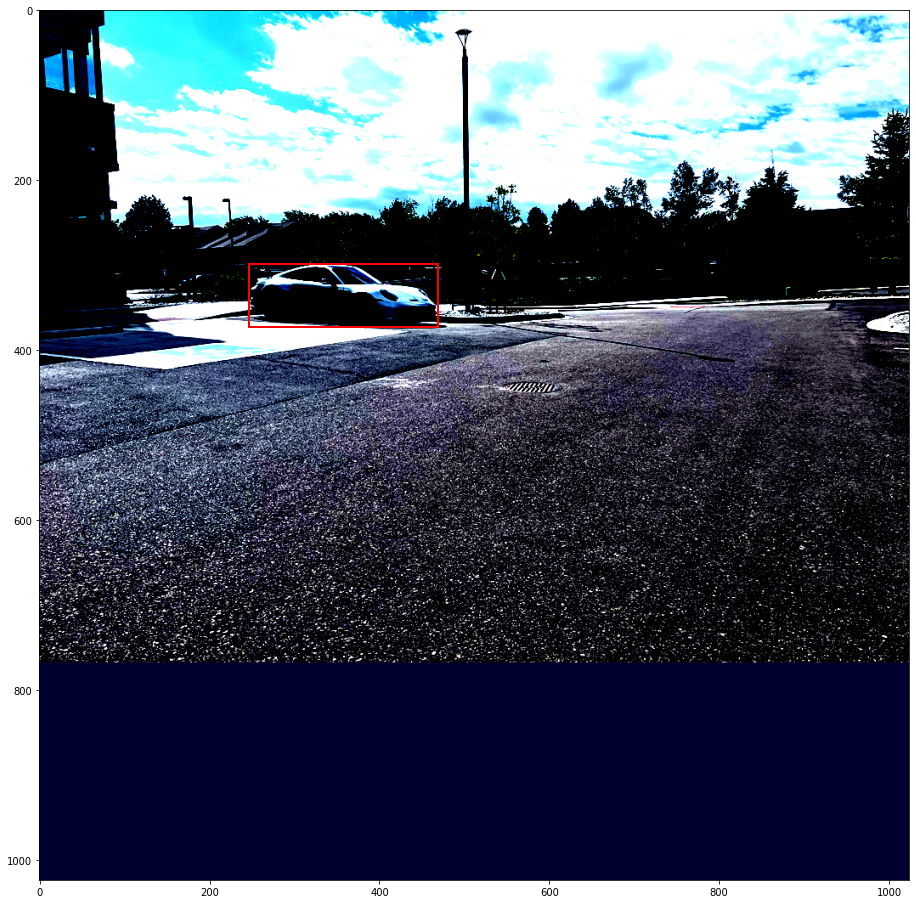

In [9]:
# plot some example test data
idx = 14
image,boxes,distances,classes = test_data.__getitem__(idx)
image,boxes,classes = image.numpy(),boxes.numpy(),classes.numpy()
fig,ax = plt.subplots(figsize=(20,16))

# # fix color pixel range
# shape = np.shape(image)
# image = image.flatten()
# min_pix = np.min(image)
# max_pix = np.max(image)
# image = np.apply_along_axis(lambda x: (x - min_pix) / (max_pix - min_pix), 0, image)
# image = np.reshape(image, shape)

ax.imshow(np.transpose(image, (1,2,0)))
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0],boxes[i][3]),boxes[i][2]-boxes[i][0],boxes[i][1]-boxes[i][3], linewidth=2, edgecolor='r', facecolor='none', label='object')
    ax.add_patch(rect)
plt.show()

In [10]:
%%capture
# load in our model
model = DistResNeXt50(n_classes=train_data.n_classes, image_size=size)
model.to(device)

In [11]:
# define our loss function
class_criterion = torch.nn.CrossEntropyLoss()
dist_criterion = torch.nn.MSELoss()

In [12]:
# define some hyperparameters
n_epochs = 60
lr = 1e-7
weight_decay=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
# define our training routine
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    
    # train loop
    running_train_loss = 0.0

    model.train()
    print('Training...')
    for i,data in enumerate(trainloader, 0):

        # grab the batch and move the batch to the gpu
        inputs,boxes,distances,classes = data[0],data[1],data[2],data[3]
        inputs = inputs.to(device)
        boxes = [b.to(device) for b in boxes]
        distances = torch.cat([d.to(device) for d in distances])
        classes = torch.cat([c.to(device) for c in classes])

        # zero param gradients
        optimizer.zero_grad()
        
        # forward, backward, optimize
#         print(inputs)
#         print(boxes)
        class_preds,distance_preds = model(inputs, boxes)
#         print(np.shape(class_preds))
#         print(np.shape(classes))
#         print(np.shape(distance_preds))
#         print(np.shape(distances))
        loss = class_criterion(class_preds.squeeze(), classes) + 10.0*dist_criterion(distance_preds.squeeze(), distances)
        running_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if (i%100)==0:
            print('batch [{0:}] - loss: {1:.3f}'.format(i,running_train_loss/(i+1)))

    # end of epoch train stats
    train_loss = running_train_loss/(i+1)
    train_losses.append(train_loss)

    # validation loop
    running_val_loss = 0.0

    model.eval()
    print('Performing eval...')
    with torch.no_grad():
        for i,data in enumerate(testloader, 0):
            
            # grab the batch and move the batch to the gpu
            inputs,boxes,distances,classes = data[0],data[1],data[2],data[3]
            inputs = inputs.to(device)
            boxes = [b.to(device) for b in boxes]
            distances = torch.cat([d.to(device) for d in distances])
            classes = torch.cat([c.to(device) for c in classes])

            # forward, backward, optimize
            class_preds,distance_preds = model(inputs, boxes)
            loss = class_criterion(class_preds.squeeze(), classes) + 10.0*dist_criterion(distance_preds.squeeze(), distances)
            running_val_loss += loss.item()

    # calculate final val loss and step scheduler
    val_loss = running_val_loss/(i+1)
    val_losses.append(val_loss)

    # save the model every epoch
#     torch.save(model.state_dict(), '/irad_mounts/lambda-quad-5-data/beholder/distnet_weights/distnet_resnext_epoch_{}.pth'.format(epoch))
    
    # print stats
    print('End of epoch stats...')
    print('--------------------------------------------------------------------------------------')
    print('epoch [{0:}] - train_loss: {1:.3f} - val_loss: {2:.3f}'.format(epoch, train_loss, val_loss))
    print('--------------------------------------------------------------------------------------')

Training...


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


batch [0] - loss: 6.193
Performing eval...
End of epoch stats...
--------------------------------------------------------------------------------------
epoch [0] - train_loss: 6.410 - val_loss: 6.769
--------------------------------------------------------------------------------------
Training...
batch [0] - loss: 8.317
Performing eval...
End of epoch stats...
--------------------------------------------------------------------------------------
epoch [1] - train_loss: 6.356 - val_loss: 6.668
--------------------------------------------------------------------------------------
Training...
batch [0] - loss: 5.762
Performing eval...
End of epoch stats...
--------------------------------------------------------------------------------------
epoch [2] - train_loss: 6.298 - val_loss: 6.566
--------------------------------------------------------------------------------------
Training...
batch [0] - loss: 5.359
Performing eval...
End of epoch stats...
--------------------------------------

In [ ]:
# plot losses
fig,ax = plt.subplots(1, sharex=True, figsize=(6,6))
ax.plot(train_losses)
ax.plot(val_losses)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'])
plt.savefig('losses.png')
plt.show()